# S2S RNN to predict next action from state

We aim to predict the next steps on time series

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [4]:
import import_ipynb

import Process_Training_Data_2

from Process_Training_Data_2 import norm
from Process_Training_Data_2 import denorm
from Process_Training_Data_2 import class_to_action
from Process_Training_Data_2 import closest_category

importing Jupyter notebook from Process_Training_Data_2.ipynb
      id_camino         D0         D1        D2   D3   D4   D5       A0   A1
0             0  85.591116  -9.250073 -4.257165  0.0  0.0  0.0 -0.05236  0.0
15            1  98.043500 -37.779358 -4.257165  0.0  0.0  0.0 -0.03491  0.0
25            2  91.272922 -36.852284 -4.257165  0.0  0.0  0.0 -0.00000  0.0
34            3  94.839433  -8.007799 -4.257165  0.0  0.0  0.0 -0.05236  0.0
52            4  69.791783 -31.305606 -4.257165  0.0  0.0  0.0 -0.00000  0.0
...         ...        ...        ...       ...  ...  ...  ...      ...  ...
2042        235  41.074009 -34.144254 -4.257165  0.0  0.0  0.0 -0.00000  0.0
2048        236  40.754941 -11.474966 -4.257165  0.0  0.0  0.0 -0.00000  0.0
2054        237  36.542365 -20.220654 -4.257165  0.0  0.0  0.0 -0.00000  0.0
2059        238  77.290122 -11.950868 -4.257165  0.0  0.0  0.0 -0.03491  0.0
2072        239  38.729629 -32.034013 -4.257165  0.0  0.0  0.0 -0.00000  0.0

[240 rows x 9

### Get the data
First Import it using pandas

In [5]:
dataset_short = Process_Training_Data_2.get_data("./data/OSPA_training_data 2 Action.csv")

action_vector = ["A0","A1"]
normed_dataset = Process_Training_Data_2.normalize_data(dataset_short,action_vector)

N_STEPS = 8
position = "post"
dataset2 = Process_Training_Data_2.padding(normed_dataset,N_STEPS,position)

In [6]:
normed_dataset["id_camino"].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

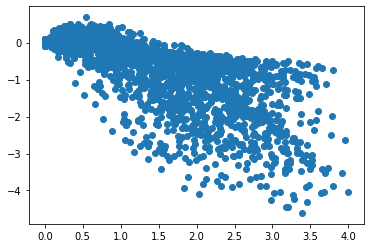

In [7]:
plt.scatter(normed_dataset["D0"], normed_dataset["D1"])

(array([241.,  45.,  61.,  52.,  45.,  42.,  37.,  33.,  53.,  52.,  49.,
         36.,  55.,  54.,  33.,  56.,  65.,  46.,  53.,  59.,  56.,  47.,
         67.,  44.,  55.,  49.,  50.,  44.,  51.,  42.,  40.,  33.,  50.,
         32.,  37.,  25.,  32.,  29.,  20.,  28.,  12.,  16.,  14.,  12.,
         10.,   6.,   3.,   4.,   0.,   3.]),
 array([4.80577202e-07, 7.98682246e-02, 1.59735969e-01, 2.39603713e-01,
        3.19471456e-01, 3.99339200e-01, 4.79206944e-01, 5.59074688e-01,
        6.38942432e-01, 7.18810176e-01, 7.98677920e-01, 8.78545664e-01,
        9.58413408e-01, 1.03828115e+00, 1.11814890e+00, 1.19801664e+00,
        1.27788438e+00, 1.35775213e+00, 1.43761987e+00, 1.51748762e+00,
        1.59735536e+00, 1.67722310e+00, 1.75709085e+00, 1.83695859e+00,
        1.91682634e+00, 1.99669408e+00, 2.07656182e+00, 2.15642957e+00,
        2.23629731e+00, 2.31616506e+00, 2.39603280e+00, 2.47590054e+00,
        2.55576829e+00, 2.63563603e+00, 2.71550378e+00, 2.79537152e+00,
        2.

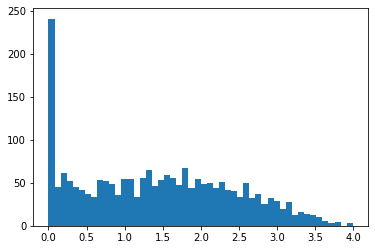

In [8]:
plt.hist(normed_dataset["D0"], bins=50)

(array([  3.,   5.,  14.,  10.,  16.,  34.,  47.,  53.,  59.,  81.,  81.,
         85., 114., 132., 183., 254., 288., 474., 130.,  15.]),
 array([-4.61939542, -4.35359225, -4.08778908, -3.82198592, -3.55618275,
        -3.29037959, -3.02457642, -2.75877325, -2.49297009, -2.22716692,
        -1.96136375, -1.69556059, -1.42975742, -1.16395426, -0.89815109,
        -0.63234792, -0.36654476, -0.10074159,  0.16506157,  0.43086474,
         0.69666791]),
 <a list of 20 Patch objects>)

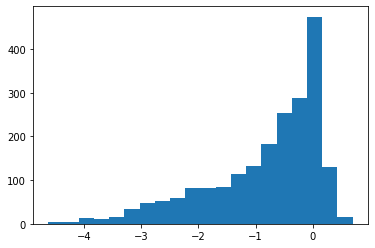

In [9]:
plt.hist(normed_dataset["D1"], bins=20)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   1.,   1.,   1.,   1.,   4.,   3.,   5.,   8.,
         11.,  29.,  38.,  73.,  68.,  72.,  92.,  63.,  93., 147.,  44.,
         41., 449.,  12.,  30., 120., 177.,  34.,   0., 539.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-7.70326126, -7.51939049, -7.33551972, -7.15164895, -6.96777818,
        -6.78390741, -6.60003664, -6.41616587, -6.2322951 , -6.04842433,
        -5.86455356, -5.68068279, -5.49681202, -5.31294125, -5.12907048,
        -4.94519971, -4.76132894, -4.57745817, -4.3935874 , -4.20971663,
        -4.02584586, -3.84197509, -3.65810432, -3.47423354, -3.29036277,
        -3.106492  , -2.92262123, -2.73875046, -2.55487969, -2.37100892,
        -2.18713815, -2.00326738, -1.81939661, -1.63552584, -1.45165507,
        -1.2677843 , -1.08391353, -0.90004276, -0.71617199, -0.53230122,
        -0.34843045, -0.16455968,  0.01931109,  0.20318186,  0.38705263,
 

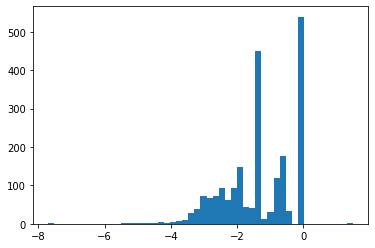

In [10]:
plt.hist(dataset2[:,:,3].flatten(), bins=50)

(array([ 20.,   2.,   2.,   3.,   1.,   7.,   6.,  10.,   6.,   5.,   8.,
          9.,  10.,  12.,  13.,  17.,  17.,  22.,  22.,  33.,  31.,  40.,
         39.,  63., 583.,  62.,  65.,  36.,  49.,  39.,  68.,  74.,  85.,
         46.,  47.,  91.,  21., 181., 114.,  13.,  41.,  23.,   9.,  79.,
          5.,  23.,   2.,   1.,   0.,   5.]),
 array([-2.80461133e+00, -2.69242597e+00, -2.58024061e+00, -2.46805525e+00,
        -2.35586989e+00, -2.24368453e+00, -2.13149918e+00, -2.01931382e+00,
        -1.90712846e+00, -1.79494310e+00, -1.68275774e+00, -1.57057238e+00,
        -1.45838702e+00, -1.34620166e+00, -1.23401630e+00, -1.12183094e+00,
        -1.00964559e+00, -8.97460227e-01, -7.85274868e-01, -6.73089509e-01,
        -5.60904150e-01, -4.48718791e-01, -3.36533432e-01, -2.24348073e-01,
        -1.12162714e-01,  2.26446865e-05,  1.12208004e-01,  2.24393363e-01,
         3.36578722e-01,  4.48764081e-01,  5.60949439e-01,  6.73134798e-01,
         7.85320157e-01,  8.97505516e-01,  1.00969

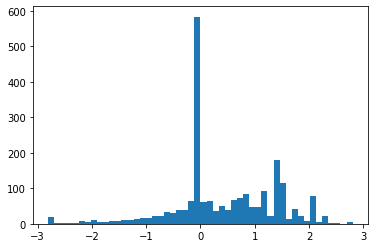

In [11]:
plt.hist(dataset2[:,:,4].flatten(), bins=50)

(array([ 20.,   2.,   2.,   3.,   1.,   7.,   6.,  10.,   6.,   5.,   8.,
          9.,  10.,  12.,  13.,  17.,  17.,  22.,  22.,  33.,  31.,  40.,
         39.,  63., 583.,  62.,  65.,  36.,  49.,  39.,  68.,  74.,  85.,
         46.,  47.,  91.,  21., 181., 114.,  13.,  41.,  23.,   9.,  79.,
          5.,  23.,   2.,   1.,   0.,   5.]),
 array([-2.80461133e+00, -2.69242597e+00, -2.58024061e+00, -2.46805525e+00,
        -2.35586989e+00, -2.24368453e+00, -2.13149918e+00, -2.01931382e+00,
        -1.90712846e+00, -1.79494310e+00, -1.68275774e+00, -1.57057238e+00,
        -1.45838702e+00, -1.34620166e+00, -1.23401630e+00, -1.12183094e+00,
        -1.00964559e+00, -8.97460227e-01, -7.85274868e-01, -6.73089509e-01,
        -5.60904150e-01, -4.48718791e-01, -3.36533432e-01, -2.24348073e-01,
        -1.12162714e-01,  2.26446865e-05,  1.12208004e-01,  2.24393363e-01,
         3.36578722e-01,  4.48764081e-01,  5.60949439e-01,  6.73134798e-01,
         7.85320157e-01,  8.97505516e-01,  1.00969

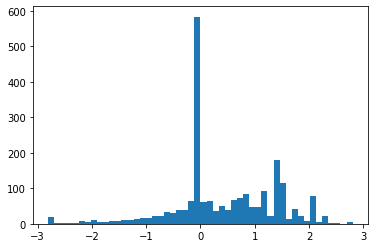

In [12]:
plt.hist(dataset2[:,:,4].flatten(), bins=50)

(array([  1.,   1.,   1.,   0.,   0.,   3.,   2.,   1.,   2.,   8.,  11.,
         12.,  18.,  25.,  60.,  93., 119., 308., 152., 807., 318., 172.,
         19.,  14.,   2.,   2.,   0.,   2.,   2.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   0.,   1.]),
 array([-6.77767405e+00, -6.42096164e+00, -6.06424924e+00, -5.70753684e+00,
        -5.35082444e+00, -4.99411204e+00, -4.63739964e+00, -4.28068723e+00,
        -3.92397483e+00, -3.56726243e+00, -3.21055003e+00, -2.85383763e+00,
        -2.49712523e+00, -2.14041282e+00, -1.78370042e+00, -1.42698802e+00,
        -1.07027562e+00, -7.13563218e-01, -3.56850817e-01, -1.38414868e-04,
         3.56573987e-01,  7.13286388e-01,  1.06999879e+00,  1.42671119e+00,
         1.78342359e+00,  2.14013599e+00,  2.49684840e+00,  2.85356080e+00,
         3.21027320e+00,  3.56698560e+00,  3.92369800e+00,  4.28041040e+00,
         4.63712281e+00,  4.99383521e+00,  5.35054

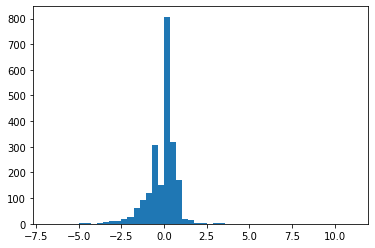

In [13]:
plt.hist(dataset2[:,:,5].flatten(), bins=50)

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [14]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, prediction_type):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, history_size)
    data.append(dataset[i,indices,:])

    if prediction_type is "single_step":
      labels.append(target[i,history_size + target_size])
    elif prediction_type is "multiple_step":
      labels.append(target[i,history_size:history_size+target_size])
    elif prediction_type  is "sequence":
      labels.append(target[i, 1:history_size + 1])   
    elif prediction_type  is "action":
      labels.append(target[i, 0:history_size])

  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [15]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
past_history = N_STEPS
future_target = 0
STEP = N_STEPS+1
prediction_type ="action"
features_dataset = dataset2[:,:,:6]
target_dataset = dataset2[:,:,6:8]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT, past_history, future_target, STEP, prediction_type)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None, past_history, future_target, STEP, prediction_type)

In [16]:
x_train_single_sequential[0]

array([[ 3.42252418, -0.86058386, -1.04955781,  0.        ,  0.        ,
         0.        ],
       [ 3.23278355, -0.7448705 , -1.45831509, -2.48326035,  0.611125  ,
         0.18785338],
       [ 2.9820536 , -0.67263644, -1.475209  , -3.23867716, -0.63976405,
        -0.98865374],
       [ 2.75571624, -0.61537664, -1.55879942, -1.62269157,  0.76949209,
         1.15680282],
       [ 2.48240517, -0.50128583, -1.69716933, -2.99318575, -0.41263161,
        -1.06054554],
       [ 2.22951858, -0.50159523, -1.48938638, -2.2492868 ,  0.0083015 ,
         0.49667227],
       [ 1.9735024 , -0.3140465 , -1.9794522 , -1.22302987,  1.17856698,
         0.81604813],
       [ 1.65373063, -0.2511935 , -1.75498629, -3.20621792, -1.22588537,
        -1.7133891 ]])

In [17]:
print ('Single window of past history : {}'.format(x_train_single_sequential[0].shape))

Single window of past history : (8, 6)


In [18]:
y_train_single_sequential[0]

array([[-0.05236,  0.     ],
       [-0.10472,  0.     ],
       [-0.     ,  0.     ],
       [-0.08727,  0.     ],
       [-0.03491,  0.     ],
       [-0.     ,  0.     ],
       [-0.10472,  0.     ],
       [-0.01745,  0.     ]])

In [19]:
BATCH_SIZE = 20
# BUFFER_SIZE = 10000

train_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_train_single_sequential, y_train_single_sequential))
train_data_single_sequential = train_data_single_sequential.cache().batch(BATCH_SIZE).repeat()

val_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_val_single_sequential, y_val_single_sequential))
val_data_single_sequential = val_data_single_sequential.batch(BATCH_SIZE).repeat()

### Build the model

In [20]:
single_step_sequential_model = tf.keras.models.Sequential()
single_step_sequential_model.add(tf.keras.layers.Masking(mask_value = 0,input_shape=(None, 6)))
single_step_sequential_model.add(tf.keras.layers.LSTM(11,return_sequences=True))
single_step_sequential_model.add(tf.keras.layers.Dense(2, activation='linear'))

single_step_sequential_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse', metrics=['mse','mae'])

### Inspect the model

In [21]:
single_step_sequential_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 6)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 11)          792       
_________________________________________________________________
dense (Dense)                (None, None, 2)           24        
Total params: 816
Trainable params: 816
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [22]:
STEPS_PER_EPOCH = TRAIN_SPLIT / BATCH_SIZE
EPOCHS = 20

single_step_sequential_history = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_single_sequential, validation_steps=50)

Train for 9.6 steps, validate for 50 steps
Epoch 1/20
10/9 [===============================] - 23s 2s/step - loss: 0.0254 - mse: 0.0281 - mae: 0.1290 - val_loss: 0.0134 - val_mse: 0.0153 - val_mae: 0.0969
Epoch 2/20
10/9 [===============================] - 0s 42ms/step - loss: 0.0104 - mse: 0.0114 - mae: 0.0833 - val_loss: 0.0067 - val_mse: 0.0077 - val_mae: 0.0685
Epoch 3/20
10/9 [===============================] - 0s 40ms/step - loss: 0.0055 - mse: 0.0061 - mae: 0.0605 - val_loss: 0.0038 - val_mse: 0.0044 - val_mae: 0.0514
Epoch 4/20
10/9 [===============================] - 0s 40ms/step - loss: 0.0034 - mse: 0.0038 - mae: 0.0464 - val_loss: 0.0025 - val_mse: 0.0028 - val_mae: 0.0405
Epoch 5/20
10/9 [===============================] - 0s 43ms/step - loss: 0.0024 - mse: 0.0027 - mae: 0.0380 - val_loss: 0.0018 - val_mse: 0.0020 - val_mae: 0.0338
Epoch 6/20
10/9 [===============================] - 0s 38ms/step - loss: 0.0018 - mse: 0.0020 - mae: 0.0329 - val_loss: 0.0014 - val_mse: 0.001

Compute the accuracy

In [23]:
N_CATEGORIES = 28
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [24]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states()

0.35416666


In [25]:
test_loss, test_mse, test_mae = single_step_sequential_model.evaluate(x_val_single_sequential,  y_val_single_sequential, verbose=2)

48/48 - 5s - loss: 3.2252e-04 - mse: 3.5692e-04 - mae: 0.0125


Visualize the model's training progress.

In [26]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

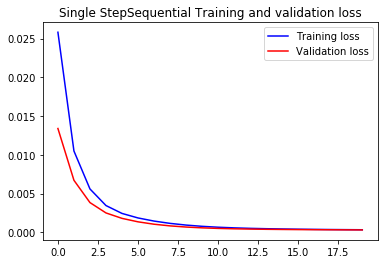

In [27]:
plot_train_history(single_step_sequential_history,
                   'Single StepSequential Training and validation loss')

#### Adding early stop

In [28]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single_sequential,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0003,  mae:0.0126,  mse:0.0004,  val_loss:0.0003,  val_mae:0.0123,  val_mse:0.0003,  
....................

In [29]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states() 

0.4375


In [30]:
single_step_sequential_model.save('./data/S2S_S2A_model.h5') 